# Movie Genre Prediction

In [5]:
import zipfile
import pandas as pd
import numpy as np
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import text_processing as tp
import joblib

# Set the seaborn style
sns.set(style="whitegrid", color_codes=True)

### Purpose of script
This script uses the ["The Movies Dataset"](https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv) 
dataset to train a model that predicts a movie's genre given its title and description. <br>
To retrain the model and reproduce the analysis, follow the link to download zipped folder and save it in the ./data folder.

### Extract data

If you haven't already unzipped the downloaded file run the cell below to unzip.

In [3]:
MOVIE_DATA_DIR = './data/archive.zip'
TARGET_DIR = './data/'

# Check if zip file exists and extract if it does
try:
    with open(MOVIE_DATA_DIR) as f:
        with zipfile.ZipFile(MOVIE_DATA_DIR, 'r') as zip_ref:
            zip_ref.extractall(TARGET_DIR)
except IOError:
    print("File not accessible")

### Load Data

In [4]:
MOVIE_DATA_DIR = './data/movies_metadata.csv'

# Load the data into a DataFrame
raw_data = pd.read_csv(MOVIE_DATA_DIR, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

We will only keep the *Genre*, *Title* and *Plot* columns for each film:

In [5]:
column_names = {'original_title': 'title',
                'overview': 'description',
                'genres': 'genres'}
movie_data = raw_data[column_names.keys()].copy()
# Rename columns
movie_data.rename(columns=column_names, inplace=True)
raw_records = len(movie_data)
print("There are {} records in the dataset.".format(raw_records))
# Display first 5 rows of dataset
movie_data.head()

There are 45466 records in the dataset.


,title,description,genres
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


### Summarise dataset information

In [6]:
unique_movies = len(movie_data['title'].unique())
print("There are {} unique movies in the dataset.".format(unique_movies))

There are 43373 unique movies in the dataset.


There are titles that contain non-english characters that need to be removed:

In [7]:
movie_data = movie_data[movie_data['title'].map(lambda x: x.isascii())].reset_index(drop=True)
english_title_movies = len(movie_data)
print("{} movies were removed from the dataset.".format(raw_records-english_title_movies))

6177 movies were removed from the dataset.


We will also remove any movies without a description or title:

In [8]:
# Exclude any movies without title or description
movie_data = movie_data.loc[~movie_data['title'].isin([''])]
movie_data = movie_data.loc[~movie_data['title'].isin([''])]
complete_movies = len(movie_data)
print("{} movies were removed from the dataset.".format(english_title_movies-complete_movies))

0 movies were removed from the dataset.


### Data pre-processing

Make sure that all datatypes are consistent:

In [9]:
# Change Title and Description types to strings
movie_data['title'] = movie_data['title'].astype(str)
movie_data['description'] = movie_data['description'].astype(str)

We now need to convert the genres column to a list of genres

In [10]:
def extract_genres(row):
    genres_list = row.replace("'", '"')  # Replace single quotes to convert to json
    genres_json = json.loads(genres_list)  # Convert string to json
    genres = [gen_dict['name'] for gen_dict in genres_json]  # Extract all genres in dict
    return genres

# Reassign the genres column to a list of the movie genres
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_genres(x))

Let's exclude any movies that do not have any genres assigned to them.

In [11]:
movie_data = movie_data[movie_data['genres'].map(lambda x: len(x)) > 0]
records_with_genres = len(movie_data)
print("{} movies were removed from the dataset.".format(complete_movies-records_with_genres))

2062 movies were removed from the dataset.


There are movies with multiple same genres that need to be removed:

In [12]:
# Get a unique list of genres for each movie
movie_data['genres'] = movie_data['genres'].apply(lambda x: list(set(x)))

Now that we have the complete dataset let's explore how many genres are available. We will use NLTK which is a natural language processing tool to get the word frequencies:

In [13]:
# Create a list of all the available genres
all_genres = [item for sublist in movie_data['genres'].values for item in sublist]
unique_genres = len(set(all_genres))
print("There are {} unique genres in the dataset.".format(unique_genres))

# Get the term frequencies
all_genres = nltk.FreqDist(all_genres)
# Create a DataFrame for plotting
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
# Before we plot let's normalise the results by the total number of movies
all_genres_df['Normalised Count'] = all_genres_df['Count'] / all_genres_df['Count'].sum()

There are 27 unique genres in the dataset.


Let's visualise the results:

In [14]:
def plot_barplot(data):
    '''
    Takes in a dataframe with Genres and Counts 
    and plots a barplot of the data.
    '''
    pal = sns.color_palette("Reds_d", len(data))
    rank = data['Normalised Count'].argsort().argsort()
    g = data.nlargest(columns="Count", n=50) 
    plt.figure(figsize=(8, 7)) 
    ax = sns.barplot(data=g, x= "Normalised Count", y = "Genre", palette=np.array(pal[::-1])) 
    ax.set(ylabel = 'Normalised Count') 
    plt.show()

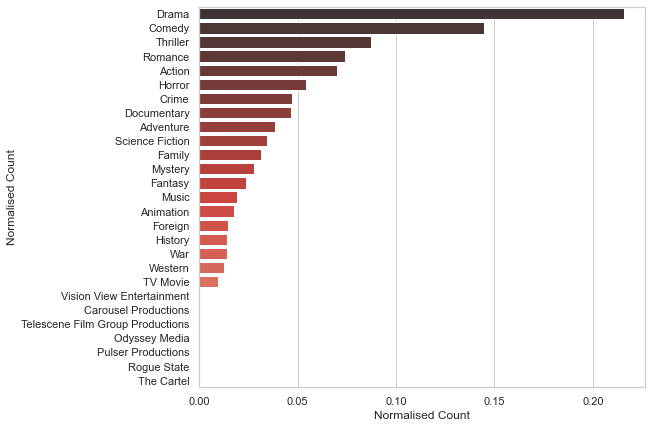

In [15]:
plot_barplot(all_genres_df)

We see that the last 7 genres do not fall under any specific category so we remove them.

In [16]:
unknown_genres = ['Carousel Productions',
                  'Vision View Entertainment',
                  'Telescene Film Group Productions',
                  'Odyssey Media',
                  'Pulser Productions',
                  'Rogue State',
                  'The Cartel']

Let's loop though all our entries and remove these genres since their count is too small.

In [17]:
def remove_genres(row):
    '''
    Loops through all genres for each film and removes
    if genre is in the unknown_genres list.
    '''
    new_items = [x for x in row if x not in unknown_genres]
    
    return new_items

# Remove unknown genres from dataset
movie_data['genres'] = movie_data['genres'].apply(lambda x: remove_genres(x))  
# Reset df index
movie_data.reset_index(drop=True, inplace=True)

In [18]:
# Create a list of all the available genres
all_genres = [item for sublist in movie_data['genres'].values for item in sublist]
unique_genres = len(set(all_genres))
print("There are {} unique genres in the dataset.".format(unique_genres))

# Get the term frequencies
all_genres = nltk.FreqDist(all_genres)
# Create a DataFrame for plotting
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
# Before we plot let's normalise the results by the total number of movies
all_genres_df['Normalised Count'] = all_genres_df['Count'] / all_genres_df['Count'].sum()

There are 20 unique genres in the dataset.


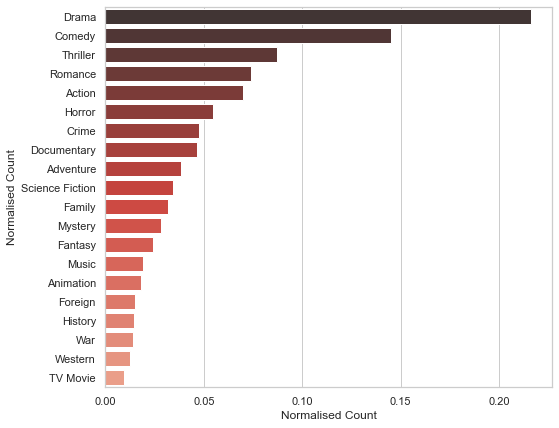

In [19]:
plot_barplot(all_genres_df)

#### Text pre-processing

Before we train any models we will need to pre-process our text. <br>
We will follow these steps:
- Join the movie title to the movie description
- Remove whitespace, slashes, non-alphabetic charactes and convert text to lowecase
- Lemmatise the words
- Remove any stopwords
- Join the title and description tokens back into one sentence

The above functions are implemented in the "text_processing.py" module.

In [20]:
movie_data['text'] = \
    movie_data[['title', 'description']].apply(
        lambda row: tp.transform_text(row['title'], row['description']), axis=1)    

# Model training

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### 1. Problem statement

This is a multi-label classification problem as a movie can belong to more than one categories. 
We are only looking to return the most likely genre to the user. <br>
There are many algorithms that are inherently multilabel and others that can be used with a One-Vs-The-Rest wrapper.

### 2. Features & Labels

First we need to one-hot encode our labels and split our features. Since no validation is set is required, we will only split between train and test.

In [22]:
# Labels
multilabel_binarizer = MultiLabelBinarizer()  # Create a multi-class binariser
y = multilabel_binarizer.fit_transform(movie_data['genres'])  # Fit the binariser to the data and transform

# Features
X = movie_data['text']

# Split data to train and test set
X_train, X_test, y_train, y_test = \
    train_test_split(X.values, y, test_size=0.15, random_state=42)

### 3. Train Model

**Pipeline** <br>
We will use the pipeline utility from scikit learn to then be able to apply the same vectoriser to the new data. <br>
**Vectorizer** <br>
We will use a TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features. <br>
**OneVsRest multi-label strategy** <br>
The Multi-label algorithm accepts a binary mask over multiple labels.  <br>
The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample. <br>
**Estimator** <br>
There are multiple different estimators that we can use including, Logistic Regression, Naive Bayes, LinearSVC. <br>
**Optimisation Metric** <br>
We will optimise the models for f1-score since we seek a balance between Precision and Recall *and* there is an uneven class distribution.

In [23]:
# Instantiate a TF-IDF vecrtorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

# Estimators to experiment
lr = LogisticRegression(solver='saga')
rf = RandomForestClassifier()  # max_depth=100
gb = GradientBoostingClassifier(random_state=0, learning_rate=1.0)  # n_estimators=100, max_depth=1, 

# List of estimators to try
estimators = [lr, rf, gb]

# Create a list of pipelines to train
pipelines = [Pipeline([('Vectorizer', tfidf_vectorizer),
                       ('Classifier', OneVsRestClassifier(estimator))]) for estimator in estimators]

# Set of parameters to optimise for
parameters_lr = {'Classifier__estimator__solver': ['lbfgs', 'saga']}
parameters_rf = {'Classifier__estimator__n_estimators': [1, 10],
                 'Classifier__estimator__max_depth': [10, 20]}
parameters_gb = {'Classifier__estimator__n_estimators': [10, 15],
                 'Classifier__estimator__max_depth': [1, 3]}

# Create a list of parameters to optimise for each estimator
parameters_list=[parameters_lr, parameters_rf, parameters_gb]

Train the pipelines for the different parameters and get the best model:

In [24]:
best_pipelines = []
# Loop through all the pipelines and train
for i in range(len(pipelines)):
    # We will use 10-fold cross-validation
    Grid = GridSearchCV(estimator=pipelines[i], param_grid=parameters_list[i], 
                        n_jobs=-1, cv=10, verbose=0, scoring='f1_micro').fit(X_train, y_train)
    best_pipelines.append(Grid.best_estimator_)

We will now train all the estimators with the best parameters and get the one with the best F1-score:

In [25]:
best_pipeline = None
f1 = 0
for pipe in best_pipelines:
    # Fit model
    pipe.fit(X_train, y_train)
    # Make predictions for test set
    y_pred_test = pipe.predict(X_test)
    # If the current model has a better f1 score than the ones so far select it 
    if f1_score(y_test, y_pred_test, average="micro") > f1:
        best_pipeline = pipe
        f1 = f1_score(y_test, y_pred_test, average="micro")
    # Evaluate model performance on the test set
    print("The F1-score for {} is {:.2f}".format(pipe['Classifier'].estimator,
                                                 f1_score(y_test, y_pred_test, average="micro")))

The F1-score for LogisticRegression(solver='saga') is 0.49
The F1-score for RandomForestClassifier(max_depth=20, n_estimators=1) is 0.23
The F1-score for GradientBoostingClassifier(learning_rate=1.0, n_estimators=15, random_state=0) is 0.41


The best model is the **One vs Rest with Logistic Regression classifier.**

If we wanted to predict as many genres for the movie as accurately as possible, we could optimise the cut-off threshold <br>
above which probabilities will be considered:

<AxesSubplot:xlabel='Threshold'>

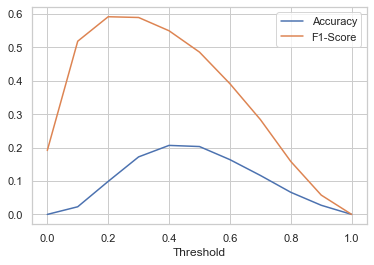

In [26]:
# Get the probabilities for each label
probabilities = best_pipeline.predict_proba(X_test)

# Calculate the metrics for different probability thresholds
scores, accuracy = {}, {}
for threshold in np.arange(0.0, 1.1, 0.1):
    # make predictions for validation set
    top_genres = np.where(probabilities > threshold, 1, 0)
    # evaluate performance
    accuracy[threshold] = accuracy_score(y_test, top_genres)
    scores[threshold] = f1_score(y_test, top_genres, average="micro")

model_accuracy = pd.DataFrame(data=accuracy.items(), index= accuracy.keys(), columns=['Threshold', 'Accuracy'])
model_f1_score = pd.DataFrame(data=scores.items(), index= scores.keys(), columns=['Threshold', 'F1-Score'])
pd.merge(model_accuracy, model_f1_score, on='Threshold').set_index('Threshold').plot()

### Test model with unseen examples:

We will load a number of different examples of movies that do not exist in the dataset to examine how the model is performing.

In [6]:
with open("examples.json", "r") as read_file:
    example_movies = json.load(read_file)

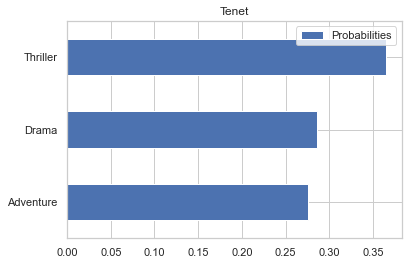

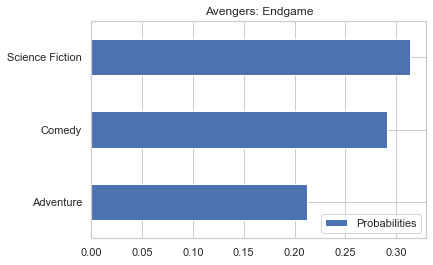

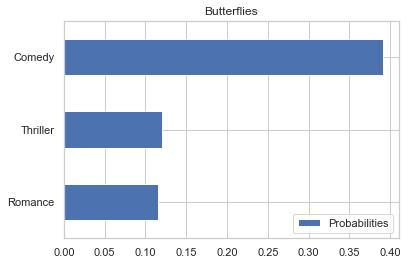

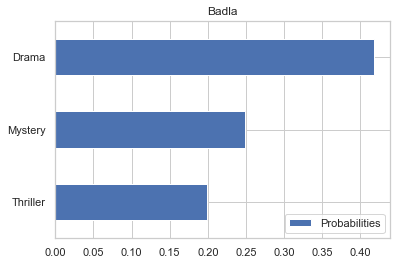

In [28]:
for title, description in example_movies.items():
    # Process raw input
    processed_data = tp.transform_text(title, description)
    # Get predictions from model
    probabilities = best_pipeline.predict_proba([processed_data])
    # Convert results to DataFrame to plot
    probabilities_df = pd.DataFrame(probabilities,
                                    index=['Probabilities'],
                                    columns=multilabel_binarizer.classes_).T
    # PLot the top 3 genres with the highest probability
    probabilities_df.sort_values(by='Probabilities', ascending=True)[-4:-1].plot.barh()
    plt.title(title)

The performance of the model is satisfactory given the requirements of our app but for <br>
experimentation purposes, we will also try to train a Neural Network.

### 4. Train a simple NN for experimentation.

This section is used to experiment training a Neural Network to benchmark its performance against the classic ML algorithms above.

In [125]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [126]:
# Labels
multilabel_binarizer = MultiLabelBinarizer()  # Create a multi-class binariser
y = multilabel_binarizer.fit_transform(movie_data['genres'])  # Fit the binariser to the data and transform

# Features
X = movie_data['text']

# Split data to train and test set
X_train, X_test, y_train, y_test = \
    train_test_split(X.values, y, test_size=0.20, random_state=42)

# Split data to train and validation set
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [132]:
# Specify hyper-parameters
vocab_size = 10000
embedding_size = 16
max_length = 500
trunc_type = "post"
oov_tok = "<OOV>"

# Create a Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Create a word index
word_index = tokenizer.word_index

# Convert sentences to sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

# Use same tokenizer in test data - a lot more OOVs might be created
validation_sentences = tokenizer.texts_to_sequences(X_val)
validation_padded = pad_sequences(validation_sentences, maxlen=max_length, truncating=trunc_type)

In [133]:
# Reverse word index
reverse_word_index = dict([(value, key) for key, value in word_index.items()])

def decode_review(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

# Examine an example
print(decode_review(training_padded[1]))
print("---------------")
print(training_sentences[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? time minor every year june nearly athlete high school college chosen amateur baseball draft play minor league inspir

In [134]:
# Define a Sequential Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  # Averages across the vector to flatten it out
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='sigmoid')])

In [135]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               1700      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 20)               

In [136]:
# Fit model
num_epochs = 50
history = model.fit(training_padded, y_train, epochs=num_epochs,
          validation_data=(validation_padded, y_val))

Epoch 1/50
838/838 [==============================] - 3s 3ms/step - loss: 5.6438 - accuracy: 0.2567 - val_loss: 5.5524 - val_accuracy: 0.2726
Epoch 2/50
838/838 [==============================] - 3s 3ms/step - loss: 5.5349 - accuracy: 0.2577 - val_loss: 5.4579 - val_accuracy: 0.2726
Epoch 3/50
838/838 [==============================] - 2s 3ms/step - loss: 5.3293 - accuracy: 0.2663 - val_loss: 5.2797 - val_accuracy: 0.2967
Epoch 4/50
838/838 [==============================] - 2s 3ms/step - loss: 5.2456 - accuracy: 0.2801 - val_loss: 5.2659 - val_accuracy: 0.2998
Epoch 5/50
838/838 [==============================] - 2s 3ms/step - loss: 5.2040 - accuracy: 0.2861 - val_loss: 5.2580 - val_accuracy: 0.3088
Epoch 6/50
838/838 [==============================] - 3s 3ms/step - loss: 5.1743 - accuracy: 0.2930 - val_loss: 5.2485 - val_accuracy: 0.3068
Epoch 7/50
838/838 [==============================] - 2s 3ms/step - loss: 5.1489 - accuracy: 0.2968 - val_loss: 5.2505 - val_accuracy: 0.3118
Epoch 

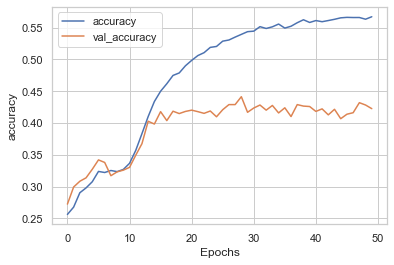

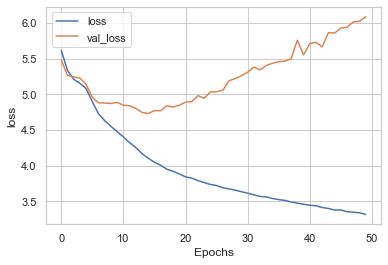

In [65]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

We can see that after around 20 epochs, the validation accuracy stops increasing even though the training <br>
set accuracy keeps increasing which means that we are overfitting out train set. <br>The model returns a probability
for each class so we can evaluate the model for different probability thresholds.

<AxesSubplot:xlabel='Threshold'>

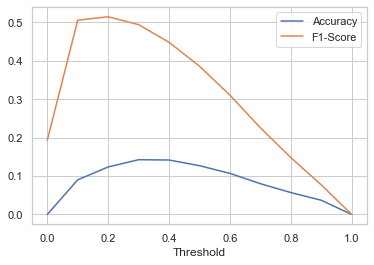

In [79]:
# Tokenise the sentences
test_sentence = tokenizer.texts_to_sequences(X_test)
# Pad the sentences so that they are all the same length
padded_sentence = pad_sequences(test_sentence, maxlen=max_length, truncating=trunc_type)
# Get the predicted probabilities for each label 
probabilities = model.predict(padded_sentence)

# Calculate the metrics for different probability thresholds
scores, accuracy = {}, {}
for threshold in np.arange(0.0, 1.1, 0.1):
    # Make predictions for validation set
    top_genres = np.where(probabilities > threshold, 1, 0)
    # Evaluate performance
    accuracy[threshold] = accuracy_score(y_test, top_genres)
    scores[threshold] = f1_score(y_test, top_genres, average="micro")

# Add outputs to a DataFrame to then join and plot
model_accuracy = pd.DataFrame(data=accuracy.items(), index= accuracy.keys(), columns=['Threshold', 'Accuracy'])
model_f1_score = pd.DataFrame(data=scores.items(), index= scores.keys(), columns=['Threshold', 'F1-Score'])
pd.merge(model_accuracy, model_f1_score, on='Threshold').set_index('Threshold').plot()

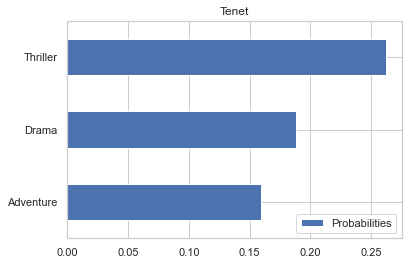

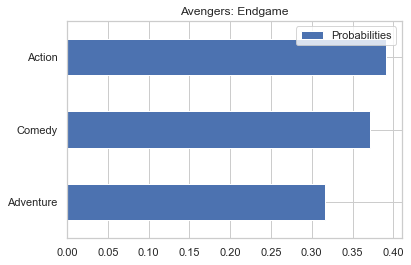

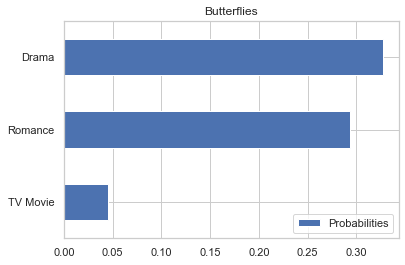

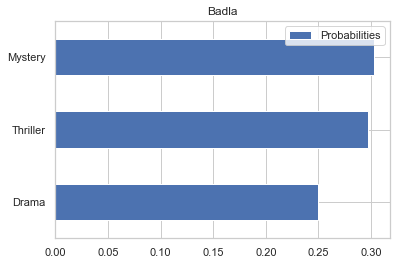

In [71]:
for title, description in example_movies.items():
    # Process raw input
    processed_data = tp.transform_text(title, description)
    # Tokenise the sentences
    test_sentence = tokenizer.texts_to_sequences([processed_data])
    # Pad the sequences so that they are all the same length
    padded_sentence = pad_sequences(test_sentence, maxlen=max_length, truncating=trunc_type)
    # Get predictions from model
    probabilities = model.predict(padded_sentence)
    # Convert results to DataFrame to plot
    probabilities_df = pd.DataFrame(probabilities,
                                    index=['Probabilities'],
                                    columns=multilabel_binarizer.classes_).T
    # Plot the top 3 genres with the highest probability
    probabilities_df.sort_values(by='Probabilities', ascending=True)[-4:-1].plot.barh()
    plt.title(title)

## Conclusions

Since there is no significant improvement over the simpler logistic regression model, <br>
we will use that in our CLI app since it is faster to train, less complex and easier to re-train, maintain and understand.

#### Additional Considerations:
- The distribution of genres is skewed so when splitting the data for training we could try to stratify the dataset and potentially oversample the minority classes.
- We could try to use alternative vectorizers (Count Vectorizer, Hash Vectorizer) and optimise the models for a higher number of parameters.
- Experiment with a bidirection LSTM layer in the NN to take into account the relationship between words.
- We could try to use a model with pre-trained embeddings. 

#### Export model to pickle:

In [29]:
model_filename = "./model/movie_classifier_trained_model.pkl"  

with open(model_filename, 'wb') as filename:  
    joblib.dump({'pipeline': best_pipeline,
                 'genres': multilabel_binarizer.classes_,
                 'metric': f1}, model_filename)